# Superpixels

A typical image may contain millions of pixels, which makes operation on images and computer vision in general pretty expensive computationally. However, most of the image is actually composed of relatively large regions of similar color. Thus, if we can identify these regions we can efficiently reduce the size of the image while keeping most of the relevant information, i.e. color and edges. Enter superpixels. "Superpixels group pixels similar in color and other low-level properties" ([Stutz et al.](https://arxiv.org/pdf/1612.01601.pdf)). They can be used to improve the computational efficiency for problems such as image segmentation, tracking, or 3-D reconstruction.

According to Stutz et al., superpixels must have the following properties: "
- **Partition**. Superpixels should define a partition of the image, i.e. superpixels should be disjoint and assign a label to every pixel.
- **Connectivity**. Superpixels are expected to represent connected sets of pixels.
- **Boundary Adherence**. Superpixels should preserve image boundaries. Here, the appropriate definition of image boundaries may depend on the application.
- **Compactness, Regularity and Smoothness**. In the absence of image boundaries, superpixels should be compact, placed regularly and exhibit smooth boundaries.
- **Efficiency**. Superpixels should be generated efficiently.
- **Controllable Number of Superpixels**. The number of generated superpixels should be controllable."

In recent years, [SLIC](https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf) has emerged as a popular algorithm for image segmentation into superpixel. Fundamentally, SLIC works by performing K-means clustering on a 5D feature space composed of color and space (xy). The CIELAB color space is prefered over RGB because it is more visually homogeneous. 

In this blogpost I will implement an algorithm for superpixel segmentation that is fundamentally similar to SLIC, i.e. clustering over color and spatial feature space. There a two important parameters in the algorithm: the relative weight given to color and spatial features (called "compactness" in SLIC), and the number of superpixels. SLIC uses an initial cluster centroid positioning and partial neighborhood calculation to speed up the computation. For the purpose of clarity and to allow for some more exploration, I ignore these aspects. Because of these different choices, I also employ a different method to ensure connectivy. My implementation is based on skimage, sklearn and numpy, with matplotlib for visualization.

# Plan to turn this notebook in a blog post

- Done: Intro about superpixel: what it is, how it is used
- Done: Quick review of state of the art, e.g. SLIC and its basic principle, show a demonstration of SLIC
- Done: Here we propose to implement a simple approach to create a similar effect by using clustering in RGBxy space
- Done: Get contours from sobel filter
- Demonstration with several parameters: scaling X and Y, spacefac: ~.0 clustering in RGB only, 1, 5, >>1 clustering in space only (voronoi diagram), 
- Artistic effects: use different functions of X, Y, e.g. sin(X)*cos(Y), or X^2, Y^2 (square delimitation)
- conclusion

# Complement

- notebook with GUI
- or notebook and GUI in streamlit
- For the cover image take some picture of a mountain or whatever and show 
    - left half: original image
    - right half: superpixeled image
    - don't make a hard boundary but select only labels whose cluster is greater than some threshold X
    - or apply a gradient when adding the two images

# Setup

We start by importing the necessary libraries and some helper functions for plotting.

In [1]:
# imports
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np
from im_func import show_image, show_multi_image, timer
import seaborn as sns
from skimage import transform
from skimage import io
from skimage import segmentation

Then, we import an image and we compute a SLIC segmentation using the skimage implementation for reference. Here, we used a compactness of 20 and 100 superpixels. We reconstruct an image for the segmentation using skimage's `label2rgb` function.

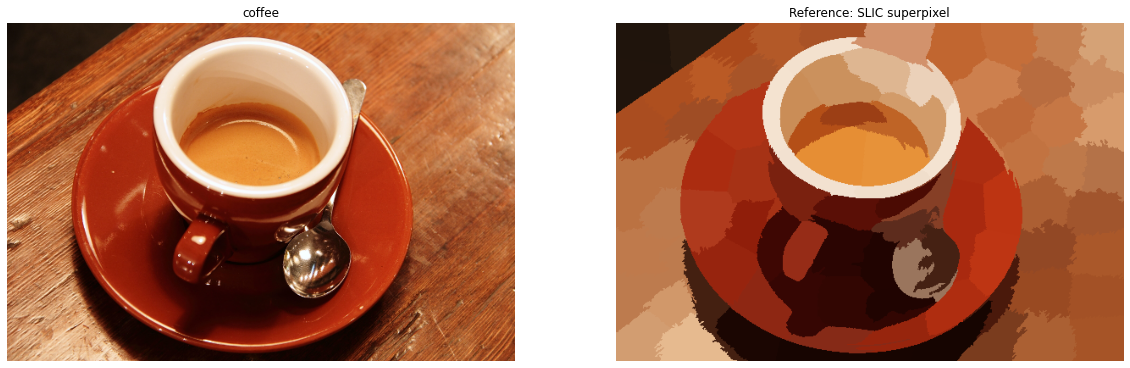

In [184]:
# Load stock image using function
title = 'coffee'
image = getattr(ski.data, title)()

# Resize the image
image = ski.transform.rescale(image,1/1,multichannel=True)

segments = segmentation.slic(image, compactness=20, n_segments=100, start_label=1)
image_SLIC = ski.color.label2rgb(segments, image, kind='avg', bg_label=0)

_ = show_multi_image(((image, title),
                      (image_SLIC, 'Reference: SLIC superpixel')),
                      figsize=[20,20])

# Our method

## 1. Clustering

First, we specify the parameters `K`, the number of clusters and `W`. `W` is a parameter that weights the importance of space compared to color, and thus serves the same purpose as compactness in SLIC. If `W`=1 space and color have equal importance; if `W`>>1, the clustering is effectively only affected by space; and if `W`~0 only color matters. 

We modify the original image in two ways: we apply a gaussian filter to reduce the noise and smooth high frequency features, and we convert the image from RGB to CIELAB color space, and scale it in the range 0-1. For space, we create two matrices to store the x and y position of every pixel. The x coordinate goes 0 to `W`, and the y coordinate from 0 to `W*width/height`.  Then, we merge color and space into a `n*5` matrix, where `n` is the number of pixels.

Finally, we apply the K-means clustering algorithm. Here we employ the `MiniBatchKMeans` function of sklearn to reduce computation time. We store the labels and cluster_centers for later use, and visualize the image as we did earlier.

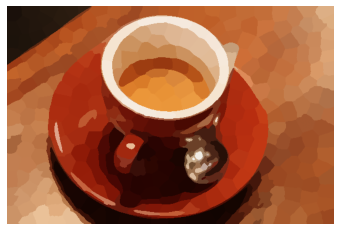

In [169]:
from sklearn.cluster import MiniBatchKMeans
K = 400
W = 3.0

# Modify original image
image_filtered = ski.filters.gaussian(image, sigma=2.0, multichannel=True)
image_filtered = ski.color.rgb2lab(image_filtered)/100.0

# Define space
X,Y = np.meshgrid(np.linspace(0,1.0*W,image.shape[0]),np.linspace(0,1.0*W*image.shape[1]/image.shape[0],image.shape[1]))
X = X.T; Y = Y.T

# Merge space and color matrices
data = np.concatenate([(image_filtered), np.stack([X,Y],axis=2)],axis=2)
data = data.reshape(image.shape[0]*image.shape[1],-1)

# Cluster
clustering = MiniBatchKMeans(n_clusters=K, random_state=12).fit(data)
labels = clustering.labels_.reshape(image.shape[:-1])
cluster_centers = clustering.cluster_centers_
cluster_centers[:,-2] *= image.shape[0]/fac
cluster_centers[:,-1] *= np.max(Y)/fac

image_seg = ski.color.label2rgb(labels, image, kind='avg')
_ = show_image(image_seg)

## 2. Enforce connectivity

Following the definition given in the introduction, superpixels should represent connected sets of pixels. But it is clear that our initial segmentation may not respect this constraint. If `W`>>1, then the the clustering is based only on spatial features, and connectivity is expected. But in the extreme case where `W`=0, pixels are grouped only by color, and therefore say, two black pixels in different corners of the image would be grouped together. To ensure the connectivity of superpixels for any values of `W` we do the following.

To verify connectivity we use a flooding algorithm. We loop over clusters. 

If a cluster is initially discontinuous, the cluster center, which is the mean of all cluster pixels may be outside 
in any First, we check that the cluster center belongs to a pixel of its own cluster.

array([[194, 194, 194, ..., 238, 238, 238],
       [194, 194, 194, ..., 238, 238, 238],
       [194, 194, 194, ..., 238, 238, 238],
       ...,
       [179, 179, 179, ..., 102, 102, 102],
       [179, 179, 179, ..., 102, 102, 102],
       [179, 179, 179, ..., 102, 102, 102]], dtype=int32)

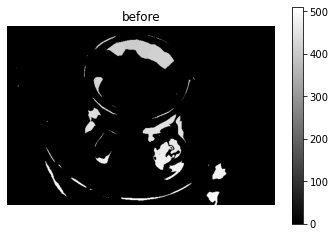

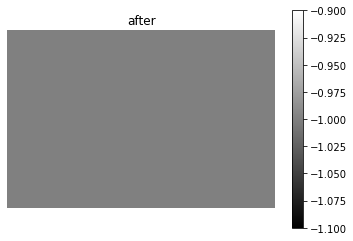

In [186]:
# c = cluster_centers[0,-2:]
# cluster_centers.shape
def enforce_connectivity(labels):
    image_flooded = labels.copy()
    ic = 0

    for i,j in cluster_centers[:,-2:].astype(int):
        if image_flooded[i,j] == ic:
            seed = (i,j)
        else: 
            # if the cluster is disconnected or has a twisty shape, the cluster_center's pixel may be outside the actual cluster
            # then find one point in the cluster
            seed = tuple(np.argwhere(image_flooded==ic)[0])

        ski.morphology.flood_fill(image_flooded, seed, -1, in_place=True)
        ic+=1

    show_image(image_flooded, 'before',show_colorbar=True)

    nseed = np.max(labels)

    disconnected = np.argwhere(image_flooded>=0)
    while len(disconnected>0):
        seed = tuple(disconnected[0])
        nseed += 1
        ski.morphology.flood_fill(labels, seed, nseed, in_place=True)
        ski.morphology.flood_fill(image_flooded, seed, -1, in_place=True)
        disconnected = np.argwhere(image_flooded>=0)

    plt.figure()
    show_image(image_flooded, 'after',show_colorbar=True)
    return labels
    
enforce_connectivity(labels) 

# Extracting edges

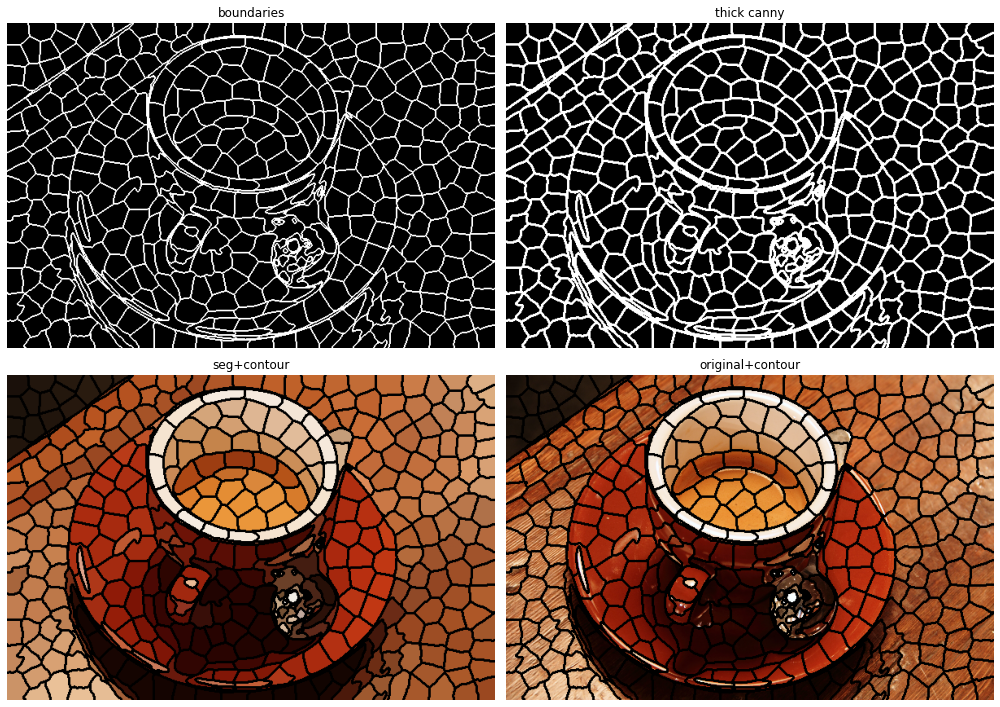

In [170]:
# Get edges and superpose them to the original picture

# im_canny = ski.feature.canny(labels/np.max(labels),sigma=0,low_threshold=0.5,high_threshold=.5,use_quantiles=True)
# im_out = ski.filters.gaussian(im_canny,sigma=.125)
# im_out /= np.max(im_out)
# im_out[im_out>.0] = 1.
im_bound = ski.segmentation.find_boundaries(labels)
im_out = ski.morphology.dilation(im_bound,selem=ski.morphology.square(2))
im_bound_thick = ski.segmentation.find_boundaries(labels)

# im_out = image_sobel
image_seg_contour = image_seg.copy()
image_contour = image.copy()
for i in range(3):
    image_seg_contour[:,:,i] *= 1.0-im_out
    image_contour[:,:,i] *= 1.0-im_out
_ = show_multi_image(((im_bound,'boundaries'),
                      (im_out,'thick canny'),
                      (image_seg_contour,'seg+contour'),
                      (image_contour,'original+contour')
                     ),figsize=[14,10],row_col=(2,2),tight_layout=True)

(<Figure size 1008x720 with 4 Axes>,
 array([<AxesSubplot:title={'center':'fac: 1.00'}>,
        <AxesSubplot:title={'center':'fac: 0.66'}>,
        <AxesSubplot:title={'center':'fac: 0.33'}>,
        <AxesSubplot:title={'center':'fac: 0.00'}>], dtype=object))

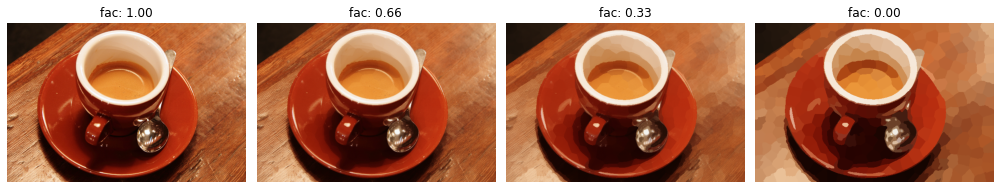

In [171]:
show_multi_image([(fac*image + (1.-fac)*image_seg, f'fac: {fac:.2f}') for fac in [1., .66, .33, .0]],
                figsize=[14,10],
                tight_layout=True)

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

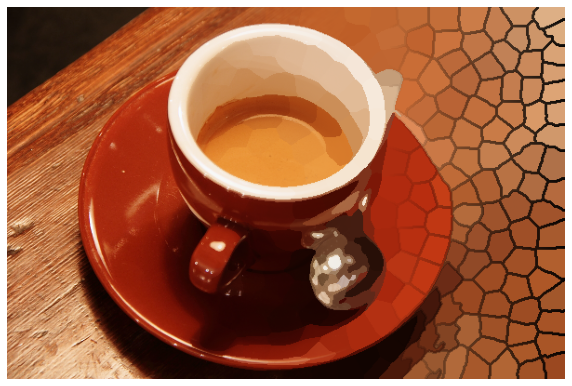

In [172]:
# Generate a combined image

ny = image.shape[1]
x = np.zeros((1,image.shape[1]))
lim = 2*ny/3

pad = 40
def crossfade_images(image1, image2, lim=ny/2, pad=5):
    # image1 and image2 should be the same size
    for i in range(x.shape[1]):
        if i < lim-pad:
            x[0,i] = 1.
        elif i > lim+pad:
            x[0,i] = 0.    
        else:
            x[0,i] = .5-(i-lim)/(2*pad)
    X = np.ones((image.shape[0],1))@x
    return (image1.T*X.T).T.reshape(image1.shape) + (image2.T*(1.-X.T)).T.reshape(image2.shape)



# # Y.shape
new_image = crossfade_images(image, image_seg,lim=ny*.45, pad=100)
new_image = crossfade_images(new_image, image_seg_contour,lim=ny*.85, pad=100)
show_image(new_image,figsize=[10,10])
# ski.io.imsave("../Data/Sakura_both_contour.png",new_image)

# Connectivity check

It's going to be really slow, but :

- loop over clusters
    - threshold the segment image for this cluster
    - run find_contour and close the countours


(<Figure size 1080x720 with 2 Axes>,
 array([<AxesSubplot:title={'center':'before'}>,
        <AxesSubplot:title={'center':'after'}>], dtype=object))

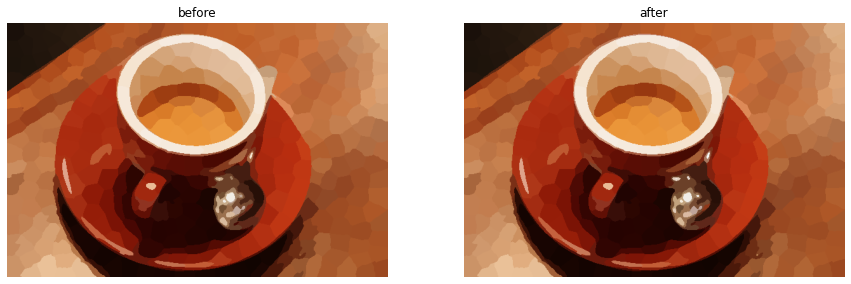

In [174]:
image_seg2 = ski.color.label2rgb(labels, image, kind='avg', bg_label=None)
show_multi_image(((image_seg,'before'),
                  (image_seg2, 'after')),
                figsize=[15,10])